In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.multinomial import Multinomial
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sys
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import log_sum_exp
from util_gmm_niw_pytorch import *
from gmm_dataset import *
import numpy as np
from spiral import *

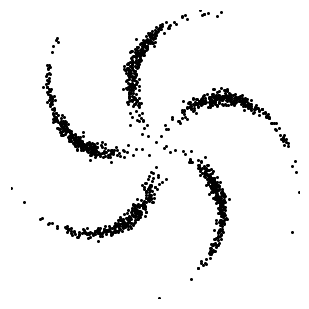

In [2]:
num_clusters = 5          # number of clusters in pinwheel data
samples_per_cluster = 300  # number of samples per cluster in pinwheel
Y = make_pinwheel_data(0.3, 0.05, num_clusters, samples_per_cluster, 0.25)
plot_data(Y)

In [3]:
K = 5               # number of components in mixture model
D = 2
N = num_clusters * samples_per_cluster
Y = torch.tensor(Y)

## Priors

In [9]:

## prior
alpha_0 = torch.ones(K).double()
m_0 = Y.mean(0)
beta_0 = 1.0
nu_0 = 6.0
W_0 =  (nu_0-D-1) * torch.mm((Y - m_0).transpose(0,1), (Y - m_0)) / (N)
cov = torch.from_numpy(np.cov(Y.transpose(0,1)))

## VBEM

In [10]:
alpha_hat = alpha_0
m = MultivariateNormal(m_0, cov)
m_ks = m.sample((K,))
beta_ks = (torch.ones(K) * beta_0).double()
nu_ks = (torch.ones(K) * nu_0).double()
W_ks = W_0.repeat(K, 1, 1)

In [11]:
iterations = 50

In [12]:
epoch_elbos = []
for i in range(iterations):
    ## VBE step
    log_gammas = vbE_step(alpha_hat, nu_ks, W_ks, m_ks, beta_ks, Y, N, D, K)
    N_ks, Y_ks, S_ks = stats(log_gammas, Y, D, K)
    ## VBM step
    alpha_hat, nu_ks, W_ks, m_ks, beta_ks, cov_ks = vbM_step(alpha_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, N, D, K)
    epoch_elbo = elbo(log_gammas, alpha_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, alpha_hat, nu_ks, W_ks, m_ks, beta_ks, Y, N, D, K)
    epoch_elbos.append(epoch_elbo)
#     print('Iteration:%d, ELBO:%f' % ((i+1), epoch_elbo))
final_covs = cov_ks.data.numpy() ## mean of inverse wishart
final_mus = m_ks.data.numpy() ## mean of gaussian
Y_np = Y.data.numpy()

NLL : -9100.065656, KL_z : 1021.116283, KL_pi : 9.987914, KL_phi 363.340602
NLL : -8864.654805, KL_z : 1180.704629, KL_pi : 9.980702, KL_phi 368.187486
NLL : -8564.567484, KL_z : 1384.366383, KL_pi : 9.969930, KL_phi 377.647818
NLL : -8138.050618, KL_z : 1624.219372, KL_pi : 9.938183, KL_phi 409.464501
NLL : -7605.505907, KL_z : 1888.009237, KL_pi : 9.881773, KL_phi 471.550364
NLL : -7199.882331, KL_z : 2112.714353, KL_pi : 9.843994, KL_phi 501.223697
NLL : -6939.995085, KL_z : 2251.618300, KL_pi : 9.825681, KL_phi 514.858957
NLL : -6804.986469, KL_z : 2313.699716, KL_pi : 9.815981, KL_phi 520.138597
NLL : -6723.388427, KL_z : 2342.569997, KL_pi : 9.811190, KL_phi 524.358485
NLL : -6664.820062, KL_z : 2358.706724, KL_pi : 9.809068, KL_phi 531.288208
NLL : -6643.446572, KL_z : 2366.843828, KL_pi : 9.808193, KL_phi 532.604217
NLL : -6633.545519, KL_z : 2370.620705, KL_pi : 9.807810, KL_phi 533.062408
NLL : -6631.603174, KL_z : 2371.177530, KL_pi : 9.807598, KL_phi 532.567494
NLL : -6631.

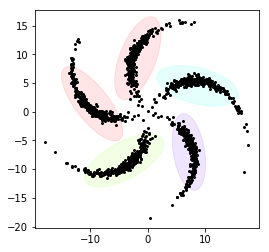

In [13]:
plot_clusters(Y_np, final_mus, cov_ks, K)